# **UNET MODEL SA-C**

In [1]:
import numpy as np

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, multiply, concatenate, Lambda, add, Activation
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing import image

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold

import os
from os import listdir

import natsort # it may need to be installed by 'pip install natsort'

import datetime
now = datetime.datetime.now

/Users/achyutaryan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from PIL import Image
import tensorflow as ft
import glob2 as glob

In [3]:
benign ='/Users/achyutaryan/Documents/Computer Vision Project/Dataset_BUSI_with_GT/benign'
malignant='/Users/achyutaryan/Documents/Computer Vision Project/Dataset_BUSI_with_GT/malignant'
normal='/Users/achyutaryan/Documents/Computer Vision Project/Dataset_BUSI_with_GT/normal'

In [4]:
count_benign=len(os.listdir(benign))
count_malignant=len(os.listdir(malignant))
count_normal=len(os.listdir(normal))

In [5]:
# Get the list of all the images
bening_cases = glob.glob(benign+ '/*')
malignant_cases =glob.glob(malignant+ '/*')
normal_cases = glob.glob(normal+ '/*')

# An empty list. We will insert the data into this list in (img_path, label) format
exclude=[]
train_data_mask = []
train_data_img=[]
# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    if img.endswith('_mask.png'):
        train_data_mask.append(img)
    elif img.endswith('_mask_2.png') or img.endswith('_mask_1.png'):
        exclude.append(img)
    else :
        train_data_img.append(img)

# Go through all the bening cases. The label for these cases will be 1
for img in bening_cases:
    if img.endswith('_mask.png'):
        train_data_mask.append(img)
    elif img.endswith('_mask_2.png') or img.endswith('_mask_1.png'):
        exclude.append(img)
    else:
        train_data_img.append(img)

# Go through all the malignant cases. The label for these cases will be 1
for img in malignant_cases:

    if img.endswith('_mask.png'):
        train_data_mask.append(img)
    elif img.endswith('_mask_1.png') or img.endswith('_mask_2.png'):
        exclude.append(img)
    else:
        train_data_img.append(img)

In [6]:
# Import necessary packages

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



def input_img(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224,224])
    return image

def normalize_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm
    

def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="ocean")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "ocean")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "ocean" )
    plt.axis("off")

In [7]:
test_model = tf.keras.applications.resnet50.ResNet50()

In [8]:
img_path = "/Users/achyutaryan/Documents/Computer Vision Project/Dataset_BUSI_with_GT/benign/benign (1).png"
input_img = input_img(img_path)

In [9]:
result = test_model(input_img)
max_idx = tf.argmax(result,axis = 1)
tf.keras.applications.imagenet_utils.decode_predictions(result.numpy())

[[('n04131690', 'saltshaker', 0.42901728),
  ('n04332243', 'strainer', 0.21202217),
  ('n09428293', 'seashore', 0.19364323),
  ('n04019541', 'puck', 0.053902373),
  ('n04553703', 'washbasin', 0.022430478)]]

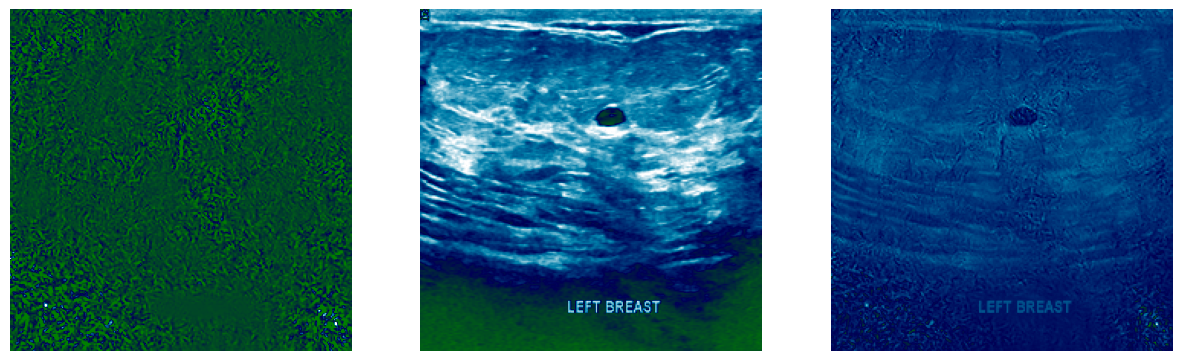

In [10]:
with tf.GradientTape() as tape:
    tape.watch(input_img)
    result = test_model(input_img)
    max_score = result[0,max_idx[0]]
grads = tape.gradient(max_score, input_img)


plot_maps(normalize_image(grads[0]), normalize_image(input_img[0]))

In [11]:
train_data_img = sorted(train_data_img)
train_data_mask = sorted(train_data_mask)

In [12]:
len(train_data_img), len(train_data_mask), len(exclude)

(780, 780, 18)

In [13]:
train_data_img[100]

'/Users/achyutaryan/Documents/Computer Vision Project/Dataset_BUSI_with_GT/benign/benign (19).png'

In [14]:
train_data_mask[100]

'/Users/achyutaryan/Documents/Computer Vision Project/Dataset_BUSI_with_GT/benign/benign (19)_mask.png'

In [15]:
images=[]
masks=[]
size_x=128
size_y=128

for every_img_path in train_data_img:
    img=cv2.imread(every_img_path,cv2.IMREAD_COLOR)
    img=cv2.resize(img,(size_y, size_x))
    images.append(img)

for every_mask_path in train_data_mask:
    mask=cv2.imread(every_mask_path,0)
    mask=cv2.resize(mask,(size_y,size_x))
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

In [16]:
x=images/255
y=masks/255

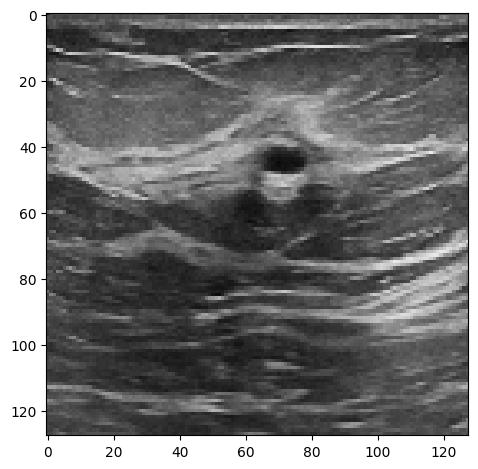

/Users/achyutaryan/Library/Python/3.9/lib/python/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


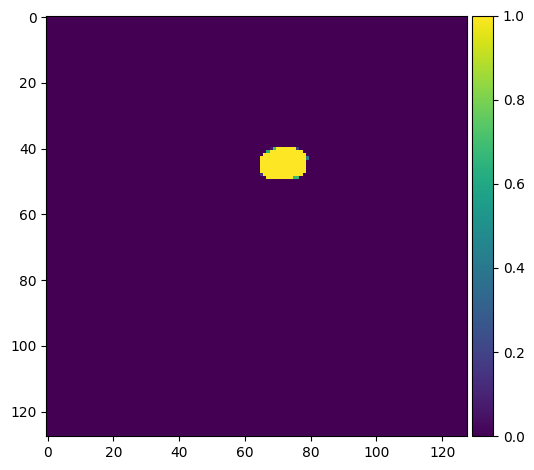

0.03529411764705882 0.9254901960784314
(128, 128, 3)
0.0 1.0
(128, 128)


In [17]:
import random
from skimage.io import imshow

########## Displaying random image from X_train and Y_train #########
random_num = random.randint(0,516)
imshow(x[random_num])
plt.show()
imshow(y[random_num])
plt.show()

test_img = x[random_num]
test_img2 = y[random_num]
print(test_img.min(), test_img.max())
print(test_img.shape)

print(test_img2.min(), test_img2.max())
print(test_img2.shape)

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    outputs = Activation('linear')(outputs)  # Add this line for saliency map


    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()

    return model

In [20]:
def get_model():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    outputs = Activation('linear')(outputs)  # Add this line for saliency map

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [21]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

In [23]:
history=model.fit(x_train,
          y_train,
          batch_size=20,
          epochs=50,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/50
32/32 [==============================] - 19s 584ms/step - loss: 0.3231 - mse: 0.0867 - val_loss: 0.2881 - val_mse: 0.0763
Epoch 2/50
32/32 [==============================] - 18s 555ms/step - loss: 0.2459 - mse: 0.0656 - val_loss: 0.2177 - val_mse: 0.0619
Epoch 3/50
32/32 [==============================] - 19s 589ms/step - loss: 0.2174 - mse: 0.0600 - val_loss: 0.2031 - val_mse: 0.0584
Epoch 4/50
32/32 [==============================] - 19s 600ms/step - loss: 0.1927 - mse: 0.0547 - val_loss: 0.2201 - val_mse: 0.0598
Epoch 5/50
32/32 [==============================] - 19s 600ms/step - loss: 0.1822 - mse: 0.0510 - val_loss: 0.1881 - val_mse: 0.0534
Epoch 6/50
32/32 [==============================] - 20s 627ms/step - loss: 0.1771 - mse: 0.0500 - val_loss: 0.1806 - val_mse: 0.0510
Epoch 7/50
32/32 [==============================] - 21s 661ms/step - loss: 0.1748 - mse: 0.0494 - val_loss: 0.1887 - val_mse: 0.0539
Epoch 8/50
32/32 [==============================] - 20s 636ms/step - 

In [25]:
import numpy as np

def dice_coef(y_true, y_pred):
    # Ensure that both y_true and y_pred have the same shape
    y_pred = y_pred.reshape(y_true.shape)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection) / (union + 1e-5)

def jaccard_index(y_true, y_pred):
    # Ensure that both y_true and y_pred have the same shape
    y_pred = y_pred.reshape(y_true.shape)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection) / (union + 1e-5)

def true_positives_ratio(y_true, y_pred):
    # Ensure that both y_true and y_pred have the same shape
    y_pred = y_pred.reshape(y_true.shape)

    true_positives = np.sum(y_true * y_pred)
    total_positives = np.sum(y_true)
    return (true_positives) / (total_positives + 1e-5)

def false_positives_ratio(y_true, y_pred):
    # Ensure that both y_true and y_pred have the same shape
    y_pred = y_pred.reshape(y_true.shape)

    false_positives = np.sum((1 - y_true) * y_pred)
    total_negatives = np.sum(1 - y_true)
    return (false_positives) / (total_negatives + 1e-5)

def global_accuracy(y_true, y_pred):
    # Ensure that both y_true and y_pred have the same shape
    y_pred = y_pred.reshape(y_true.shape)

    correct_predictions = np.sum((y_true == 1) & (y_pred >= 0.5)) + np.sum((y_true == 0) & (y_pred < 0.5))
    total_predictions = y_true.size
    return (correct_predictions) / (total_predictions + 1e-5)

# Calculate metrics
y_pred = model.predict(x_val)  # Replace with your validation data
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks

dsc = dice_coef(y_val, y_pred)
ji = jaccard_index(y_val, y_pred)
tpr = true_positives_ratio(y_val, y_pred)
fpr = false_positives_ratio(y_val, y_pred)
acc = global_accuracy(y_val, y_pred)

print(f"Dice Similarity Coefficient (DSC): {dsc}")
print(f"Jaccard Index (JI): {ji}")
print(f"True Positives Ratio (TPR): {tpr}")
print(f"False Positives Ratio (FPR): {fpr}")
print(f"Global Accuracy (ACC): {acc}")


5/5 [==============================] - 1s 200ms/step
Dice Similarity Coefficient (DSC): 0.7339176589994759
Jaccard Index (JI): 0.579676088381026
True Positives Ratio (TPR): 0.6369057205777034
False Positives Ratio (FPR): 0.008171116295382398
Global Accuracy (ACC): 0.9636484781863338


https://www.kaggle.com/code/owaistahir/unet-for-breast-cancer-tumors-segmentation
